# Introducing Distributed Word Vectors

- 단순 요약하자면 Word2vec은 2013년 구글에서 발표되었고, neural network를 적용한 알고리즘이다. 다른 RNN같은 알고리즘에 비해서 학습시간이 굉장히 짧고 Word2vec은 따로 label을 정의하지 않아도 된다. 
- 원래는 C로 짜여진 알고리즘이며 여러 다른 언어로 변환되어 사용되고 있다.


# Using word2vec in Python
- python에서는 gensim 이라는 패키지를 통해서 사용할 수 있다. 따로 GPU를 사용하지 않으며 Google's version과 Python version 모두 multi-threading 사용이 가능하다. 시간을 단축시키고 싶다면 cython을 설치하면 된다.

# Reference

- ratsgo님의 블로그 포스팅: https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/30/word2vec/
- 오늘코드의 프로그래밍 강의: https://programmers.co.kr/learn/courses/21/lessons/1698

# Preparing to Train a Model

In [13]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [4]:
# Read data from files 
train = pd.read_csv( "../dataset/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "../dataset/testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "../dataset/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print("Read %d labeled train reviews, %d labeled test reviews, and %d unlabeled reviews\n" % (train["review"].size, test["review"].size, unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [11]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

이전과 같이 nltk에서 punkt를 사용하기 위해서는 nltk.download('punkt')를 해주어야한다.

In [8]:
# nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wogur\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [10]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

위에서 정의한 함수를 통해서 Word2vec에 들어갈 input 데이터를 만든다.

In [14]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

print("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences from training set
Parsing sentences from unlabeled set


In [18]:
print(len(sentences))
print('sentences[0]: ',sentences[0])
print('sentences[1]: ',sentences[1])

795538
sentences[0]:  ['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']
sentences[1]:  ['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent']


In [30]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, 
                          size=num_features, min_count = min_word_count,
                          window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "../saved_model/300features_40minwords_10context"
model.save(model_name)

2019-05-23 13:32:52,453 : INFO : collecting all words and their counts
2019-05-23 13:32:52,453 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-05-23 13:32:52,487 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2019-05-23 13:32:52,526 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types
2019-05-23 13:32:52,557 : INFO : PROGRESS: at sentence #30000, processed 671315 words, keeping 30034 word types
2019-05-23 13:32:52,586 : INFO : PROGRESS: at sentence #40000, processed 897815 words, keeping 34348 word types
2019-05-23 13:32:52,618 : INFO : PROGRESS: at sentence #50000, processed 1116963 words, keeping 37761 word types
2019-05-23 13:32:52,649 : INFO : PROGRESS: at sentence #60000, processed 1338404 words, keeping 40723 word types


Training model...


2019-05-23 13:32:52,684 : INFO : PROGRESS: at sentence #70000, processed 1561580 words, keeping 43333 word types
2019-05-23 13:32:52,718 : INFO : PROGRESS: at sentence #80000, processed 1780887 words, keeping 45714 word types
2019-05-23 13:32:52,751 : INFO : PROGRESS: at sentence #90000, processed 2004996 words, keeping 48135 word types
2019-05-23 13:32:52,782 : INFO : PROGRESS: at sentence #100000, processed 2226966 words, keeping 50207 word types
2019-05-23 13:32:52,813 : INFO : PROGRESS: at sentence #110000, processed 2446580 words, keeping 52081 word types
2019-05-23 13:32:52,846 : INFO : PROGRESS: at sentence #120000, processed 2668775 words, keeping 54119 word types
2019-05-23 13:32:52,882 : INFO : PROGRESS: at sentence #130000, processed 2894303 words, keeping 55847 word types
2019-05-23 13:32:52,915 : INFO : PROGRESS: at sentence #140000, processed 3107005 words, keeping 57346 word types
2019-05-23 13:32:52,958 : INFO : PROGRESS: at sentence #150000, processed 3332627 words, ke

2019-05-23 13:32:55,249 : INFO : PROGRESS: at sentence #790000, processed 17674981 words, keeping 123066 word types
2019-05-23 13:32:55,267 : INFO : collected 123504 word types from a corpus of 17798082 raw words and 795538 sentences
2019-05-23 13:32:55,268 : INFO : Loading a fresh vocabulary
2019-05-23 13:32:55,321 : INFO : effective_min_count=40 retains 16490 unique words (13% of original 123504, drops 107014)
2019-05-23 13:32:55,321 : INFO : effective_min_count=40 leaves 17238940 word corpus (96% of original 17798082, drops 559142)
2019-05-23 13:32:55,359 : INFO : deleting the raw counts dictionary of 123504 items
2019-05-23 13:32:55,361 : INFO : sample=0.001 downsamples 48 most-common words
2019-05-23 13:32:55,362 : INFO : downsampling leaves estimated 12749658 word corpus (74.0% of prior 17238940)
2019-05-23 13:32:55,400 : INFO : estimated required memory for 16490 words and 300 dimensions: 47821000 bytes
2019-05-23 13:32:55,401 : INFO : resetting layer weights
2019-05-23 13:32:55

2019-05-23 13:33:27,685 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-05-23 13:33:27,689 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-05-23 13:33:27,690 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-05-23 13:33:27,694 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-05-23 13:33:27,697 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-05-23 13:33:27,701 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-05-23 13:33:27,702 : INFO : EPOCH - 5 : training on 17798082 raw words (12748171 effective words) took 6.4s, 2005363 effective words/s
2019-05-23 13:33:27,702 : INFO : training on a 88990410 raw words (63744587 effective words) took 32.1s, 1983515 effective words/s
2019-05-23 13:33:27,702 : INFO : precomputing L2-norms of word weight vectors
2019-05-23 13:33:27,711 : INFO : saving Word2Vec object under ../saved_model/300features_40minwords_10con

# Exploring the Model Results

doesnt_match 함수는 단어들간 가장 비슷하지 않은 단어를 골라준다.

In [21]:
model.doesnt_match("man woman child kitchen".split())

'kitchen'

In [22]:
model.doesnt_match("france england germany berlin".split())

'berlin'

In [23]:
model.doesnt_match("paris berlin london austria".split())

'paris'

most_similar 함수는 모델의 단어 군집들에 대한 insight를 제공한다.

In [24]:
model.most_similar("man")

[('woman', 0.6255667209625244),
 ('lady', 0.5956610441207886),
 ('lad', 0.557716965675354),
 ('businessman', 0.5452080368995667),
 ('millionaire', 0.5300158262252808),
 ('farmer', 0.521920382976532),
 ('men', 0.5185505151748657),
 ('guy', 0.5126590132713318),
 ('monk', 0.5045579671859741),
 ('boy', 0.5037210583686829)]

In [25]:
model.most_similar("queen")

[('princess', 0.6652853488922119),
 ('bride', 0.6276909112930298),
 ('belle', 0.6244186162948608),
 ('nun', 0.5838934779167175),
 ('stepmother', 0.5785307884216309),
 ('goddess', 0.5716500282287598),
 ('maid', 0.5714686512947083),
 ('mistress', 0.5687933564186096),
 ('regina', 0.5679835081100464),
 ('dame', 0.5643784999847412)]

In [26]:
model.most_similar("awful")

[('terrible', 0.7717123627662659),
 ('atrocious', 0.7414578199386597),
 ('horrible', 0.7341980934143066),
 ('dreadful', 0.7187994122505188),
 ('abysmal', 0.7159116268157959),
 ('horrendous', 0.686681866645813),
 ('appalling', 0.6756196618080139),
 ('horrid', 0.6660269498825073),
 ('lousy', 0.6544520854949951),
 ('laughable', 0.6129556894302368)]

In [29]:
model.most_similar("wogur")

KeyError: "word 'wogur' not in vocabulary"

# Word2Vec으로 벡터화 한 단어를 t-SNE 를 통해 시각화

In [38]:
list(model.wv.vocab)[:10]

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'mj']

In [41]:
model['with']

array([ 0.02643581,  0.03648249,  0.02493487, -0.02878957, -0.02446295,
        0.13544144,  0.00354865,  0.00892634, -0.04108397, -0.09993073,
       -0.04959227,  0.05202818, -0.03863294, -0.08301222,  0.1030677 ,
       -0.09737502,  0.09477071, -0.03942499, -0.03640972,  0.05705859,
        0.00080944, -0.00191526,  0.06136103, -0.04709464, -0.01612598,
       -0.0463567 , -0.00310672, -0.05058523,  0.01568329, -0.03966827,
        0.07884071,  0.0597889 , -0.00463029,  0.05344667,  0.10254774,
       -0.07189681, -0.07769471,  0.11854357, -0.08434708,  0.03794815,
       -0.10524242, -0.02746587,  0.01221603, -0.07161284,  0.1020612 ,
        0.05789941,  0.03912612, -0.01143014, -0.04747194,  0.06238569,
       -0.04224473, -0.04363997, -0.08573589, -0.04628644, -0.05150528,
       -0.02760129, -0.01594119, -0.05623262, -0.12797204, -0.06993271,
        0.04381479,  0.03646931, -0.01184009, -0.0024474 , -0.00456398,
       -0.02419178,  0.07297916, -0.00556381, -0.00116474,  0.05

In [43]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
# mpl.rcParams['axes.unicode_minus'] = False

model_name = '../saved_model/300features_40minwords_10context'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

2019-05-23 13:37:53,209 : INFO : loading Doc2Vec object from ../saved_model/300features_40minwords_10context
2019-05-23 13:37:53,210 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-23 13:37:53,441 : INFO : loading wv recursively from ../saved_model/300features_40minwords_10context.wv.* with mmap=None
2019-05-23 13:37:53,442 : INFO : setting ignored attribute vectors_norm to None
2019-05-23 13:37:53,442 : INFO : loading vocabulary recursively from ../saved_model/300features_40minwords_10context.vocabulary.* with mmap=None
2019-05-23 13:37:53,443 : INFO : loading trainables recursively from ../saved_model/300features_40minwords_10context.trainables.* with mmap=None
2019-05-23 13:37:53,443 : INFO : setting ignored attribute cum_table to None
2019-05-23 13:37:53,444 : INFO : loaded ../saved_model/300features_40minwords_10context


16490
[ 0.02643581  0.03648249  0.02493487 -0.02878957 -0.02446295  0.13544144
  0.00354865  0.00892634 -0.04108397 -0.09993073]


In [44]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [45]:
df.head(10)

,x,y
with,1.102341,7.691818
all,-1.647394,2.127686
this,-0.770990,-1.994248
stuff,0.535544,-1.166960
going,-3.495340,0.868432
down,-1.562716,8.821853
at,-2.116982,6.508572
the,1.268762,-6.067843
moment,2.824746,-4.277188
mj,8.783574,-0.385116


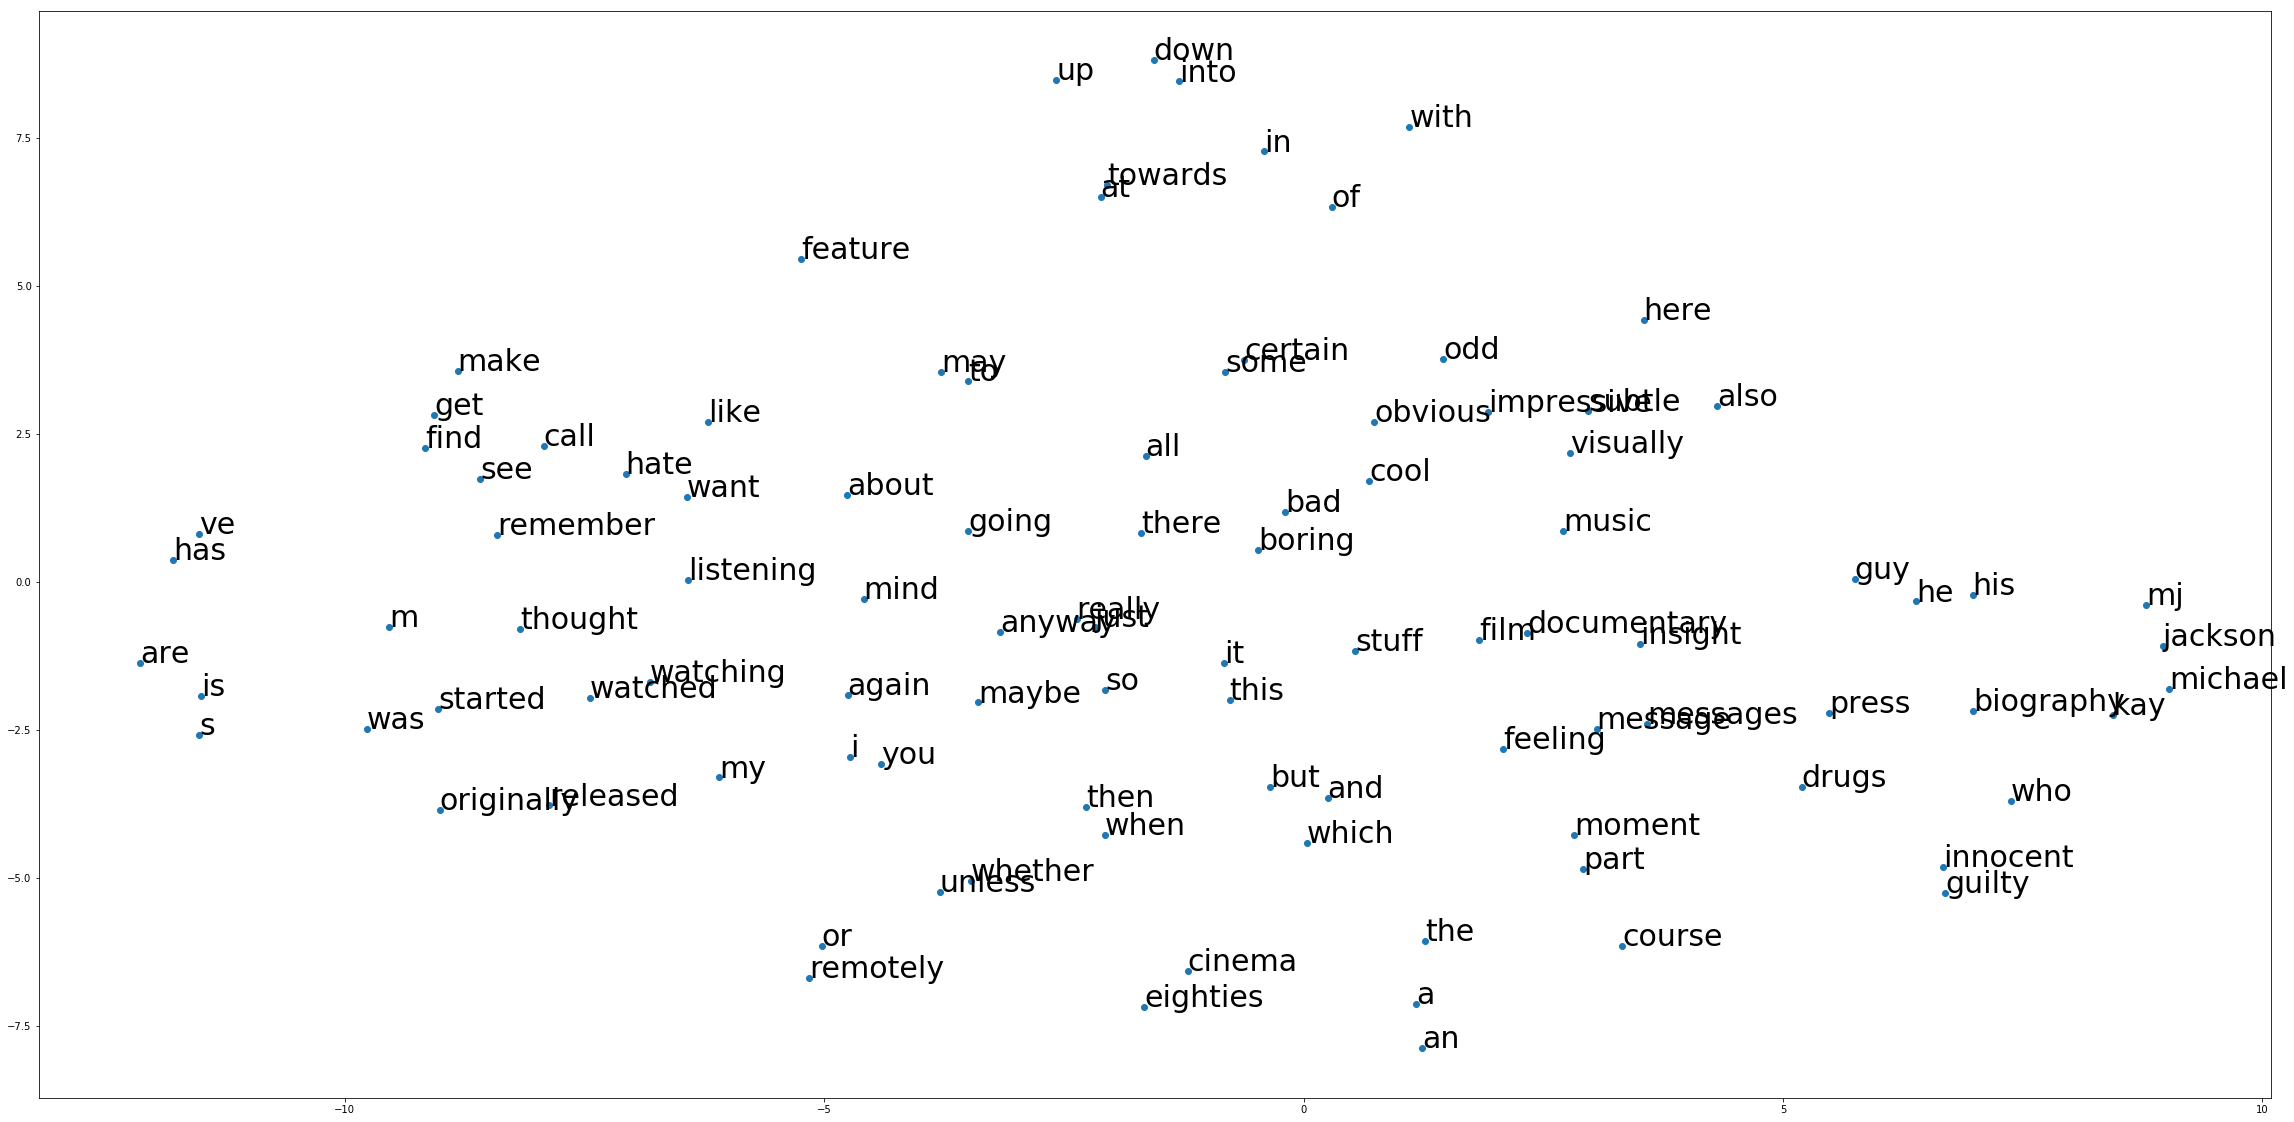

In [47]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(x='x',y='y',data=df)

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()